![](http://prod-upp-image-read.ft.com/4fec4450-0417-11e5-a70f-00144feabdc0)

<div align="center"><u><h1>Plankton Classification Challenge</h1></u></div>
 <div align="center"><h3>This notebook has been prepared on the Plankton Classification Challenge .</h3></div>
 <div align="center">This not only holds the solution but also is a nice</div>
  <div align="center">starter notebook for image classification with PyTorch</div>

At first we need to understand the steps that how we are going to solve the whole challenge by conquering every small step.

# Libraries :
---

In [1]:
# Manipulation Libraries

from termcolor import cprint
import os
from glob import glob
import random
from warnings import filterwarnings
filterwarnings('ignore')


# supporting libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random

#importing pytorch and associated libraries

import torch
import torch.nn as nn
from torchvision import transforms as transforms
from torch.utils.data import Dataset, DataLoader

 # Unzipping data :
 ---
 
 Now we are unzipping the train, test and the sample submission to check which type of data we should be feeding to the model and what should be the output format.

In [2]:
# unzipping train folder
!unzip -q ../input/datasciencebowl/train.zip

In [3]:
# unzipping test folder
!unzip -q ../input/datasciencebowl/test.zip

In [4]:
#unzipping sample submission file
!unzip ../input/datasciencebowl/sampleSubmission.csv.zip

Archive:  ../input/datasciencebowl/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


After checking the input format we can see that the images of the train folder are stored in the folders as per their class names and the test data has only one folder containing all the images.

The sample submission has the name of the images and the the probabilty of the classes. So, we need to calculate the the softmax prediction of the classes.

Thus the problem can be achieved by a simple classification using a softmax layer at the bottom of the prediction.

# Class Distribution :
---

 We should be aware of the class distributions cause every single class it's significance in this scenario.

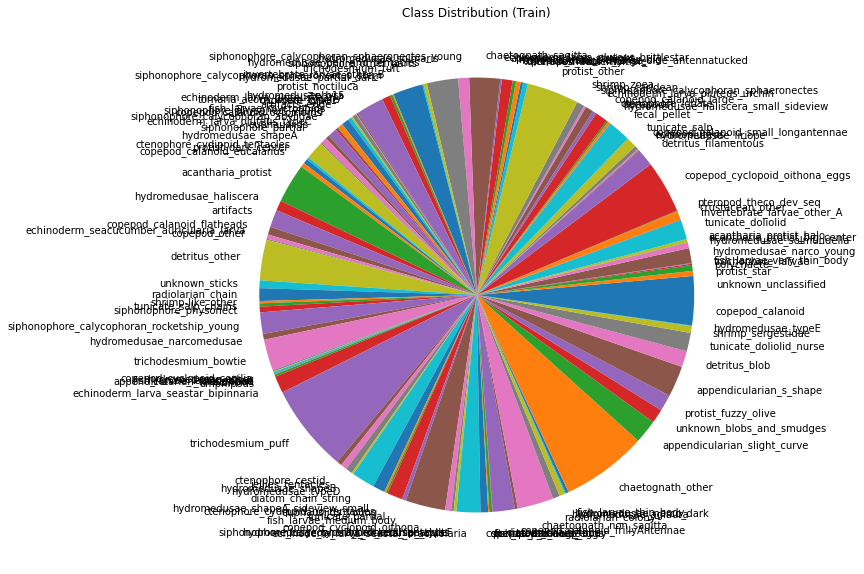

In [5]:
# Class distribution in PIE_CHART 

class_names = []
class_count = []

for name in os.listdir('./train/'):
    class_names.append(name)
    class_count.append(len(os.listdir(f'./train/{name}')))
plt.figure(figsize=(10, 10))
plt.pie(class_count, labels = class_names)
plt.title('Class Distribution (Train)')
plt.show()

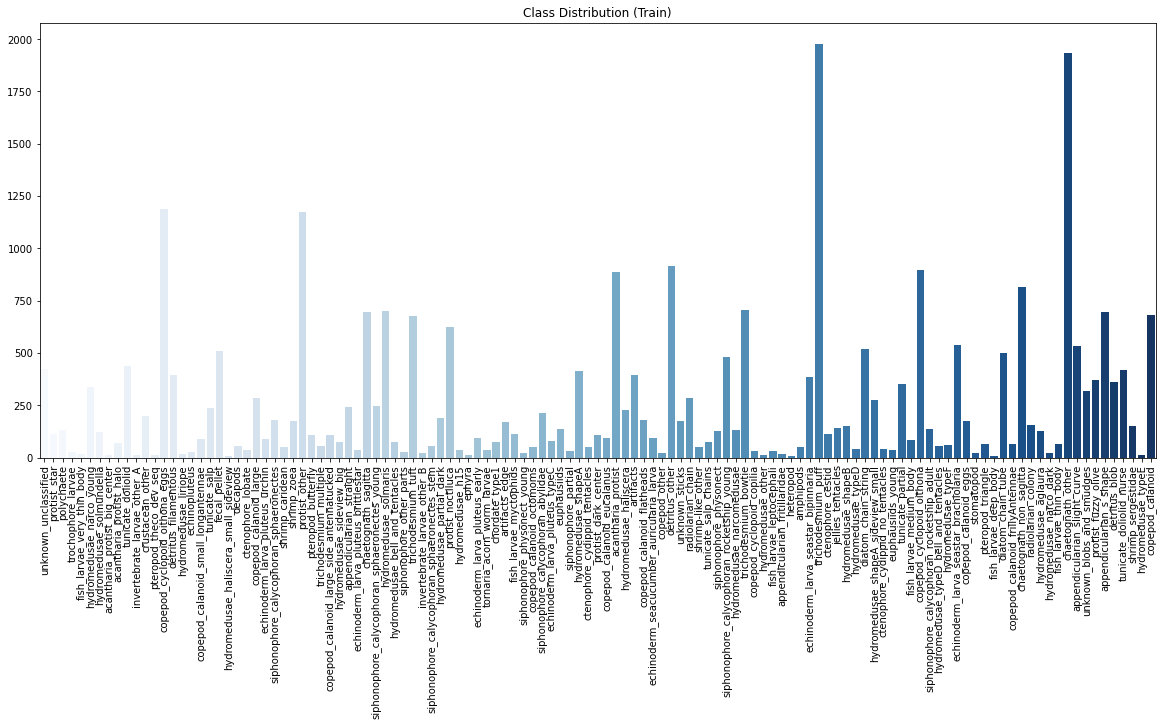

In [6]:
# Class distribution in BAR-PLOT

plt.figure(figsize=(20, 8))
sns.barplot(class_names, class_count, palette = 'Blues')
plt.title('Class Distribution (Train)')
plt.xticks(rotation=90)
plt.show()

In [7]:
# fixing the seeds

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Model Generation :
---

The model we are going to train for this chalenge will be a custom Convoltuional Neural Network. Primarily we will be updating some conv layers then we will flatten the whole image and then we will feed that through fully connected networks to generate outputs.

In [8]:
# Neural Network blocks and models

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kerel_size = 3, stride = 1, padding = 0):
        super(Conv, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kerel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.seq(x)

class PlankNet(nn.Module):
    def __init__(self, in_channels, num_classes, H = 128, W = 128):
        super(PlankNet, self).__init__()
        self.model = nn.Sequential(
            Conv(in_channels, 32), #126
            nn.MaxPool2d(2), #63
            Conv(32, 64), #61
            Conv(64, 64), #59
            nn.MaxPool2d(2), # 29
            Conv(64, 128), # 27
            nn.Dropout(0.2),
            Conv(128, 64), # 25
            Conv(64, 32), # 25
            nn.Flatten(),
            nn.Linear(32*23*23 , 4096),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        return self.model(x)
num_classes = len(class_names)
model = PlankNet(3, num_classes, 128, 128)

In [9]:
cprint(model, "blue")

PlankNet(
  (model): Sequential(
    (0): Conv(
      (seq): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      

In [10]:
# Model layers overview

for name, param in model.named_parameters():
    print(f"{name} : {param.shape}")

model.0.seq.0.weight : torch.Size([32, 3, 3, 3])
model.0.seq.0.bias : torch.Size([32])
model.0.seq.2.weight : torch.Size([32])
model.0.seq.2.bias : torch.Size([32])
model.2.seq.0.weight : torch.Size([64, 32, 3, 3])
model.2.seq.0.bias : torch.Size([64])
model.2.seq.2.weight : torch.Size([64])
model.2.seq.2.bias : torch.Size([64])
model.3.seq.0.weight : torch.Size([64, 64, 3, 3])
model.3.seq.0.bias : torch.Size([64])
model.3.seq.2.weight : torch.Size([64])
model.3.seq.2.bias : torch.Size([64])
model.5.seq.0.weight : torch.Size([128, 64, 3, 3])
model.5.seq.0.bias : torch.Size([128])
model.5.seq.2.weight : torch.Size([128])
model.5.seq.2.bias : torch.Size([128])
model.7.seq.0.weight : torch.Size([64, 128, 3, 3])
model.7.seq.0.bias : torch.Size([64])
model.7.seq.2.weight : torch.Size([64])
model.7.seq.2.bias : torch.Size([64])
model.8.seq.0.weight : torch.Size([32, 64, 3, 3])
model.8.seq.0.bias : torch.Size([32])
model.8.seq.2.weight : torch.Size([32])
model.8.seq.2.bias : torch.Size([32])


# Dataset Generation :
---

Now we will be creating the dataset which will be fed through the CNN-Model.
The training data will be splitted in training and validation for checking the model performance.

Firstly in this step we will create the dataframe eith which we will acces each data elements and it's additional features.
Then we will create the dataset class and then fit that though dataloader which will create batches of data to feed into the model.

In [11]:
#Generating csv file to gather data of images 

def generate_csv(root,train = True, img_ext = 'jpg'):
    df = pd.DataFrame(columns = ['path', 'class'])
    if train:
        for index,label in enumerate(os.listdir(root)):
            links = glob(f"{root}/{label}/*{img_ext}")
            temp_df = pd.DataFrame({'path': links, 'class': np.ones(len(links), dtype='float32')*index})
            df = pd.concat([df, temp_df], axis = 0)
    else:
        links = glob(f"{root}/*{img_ext}")
        temp_df = pd.DataFrame({'path': links, 'class': np.ones(len(links), dtype = 'float32')})
        df = pd.concat([df, temp_df], axis = 0)
        
    return df
        

In [12]:
train_csv = generate_csv('./train')
train_csv.head()

,path,class
0,./train/unknown_unclassified/151768.jpg,0.0
1,./train/unknown_unclassified/67906.jpg,0.0
2,./train/unknown_unclassified/92266.jpg,0.0
3,./train/unknown_unclassified/108660.jpg,0.0
4,./train/unknown_unclassified/87421.jpg,0.0


In [13]:
test_csv = generate_csv('./test',train = False)
test_csv.head()

,path,class
0,./test/73387.jpg,1.0
1,./test/110676.jpg,1.0
2,./test/151266.jpg,1.0
3,./test/9406.jpg,1.0
4,./test/159307.jpg,1.0


As we can see that the names are not sorted as shown n the sample submission , so we need to sort the label names of the test data.

In [14]:
# sorting the image by their names

test_csv.sort_values('path', inplace = True)
test_csv.head()

,path,class
127253,./test/1.jpg,1.0
118571,./test/10.jpg,1.0
53890,./test/100.jpg,1.0
94929,./test/1000.jpg,1.0
69001,./test/10000.jpg,1.0


In [15]:
# Genrating dataset classes

def load_image(path , H, W):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H,W))
    return img

def transform():
    return transforms.Compose([
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ])


class PlanktonDataset(Dataset):
    def __init__(self, df, H = 128, W = 128, transform = None):
        super(PlanktonDataset, self).__init__()
        self.df = df
        self.H = H
        self.W = W
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        path = self.df.iloc[index, 0]
        img = load_image(path, H = self.H, W = self.W)
        label = self.df.iloc[index, 1]
        img = Image.fromarray(img)
        if self.transform != None:
            img = self.transform()(img)
        else:
            img = transforms.ToTensor()(img)
        return (img, (label, path))
    
# Creating the train and test datasets.   
train_ds = PlanktonDataset(train_csv, 128, 128, transform = transform)
test_ds = PlanktonDataset(test_csv, 128, 128)

In [16]:
# data access format

image, label = test_ds.__getitem__(3)
image.shape, label[0], label[1]

(torch.Size([3, 128, 128]), 1.0, './test/1000.jpg')

The train-validation split is taken 3:1 (75% - 25%)

In [17]:
# Train-Validation Split :

spl_idx = int(train_ds.__len__() * 0.75)
print(f"Splitting index : {spl_idx}")
train_ds, val_ds = torch.utils.data.random_split(train_ds,[spl_idx, train_ds.__len__() - spl_idx] )

Splitting index : 22752


In [18]:
print(f"SIze of train dataset : {train_ds.__len__()}")
print(f"SIze of validation dataset : {val_ds.__len__()}")
print(f"SIze of test dataset : {test_ds.__len__()}")

SIze of train dataset : 22752
SIze of validation dataset : 7584
SIze of test dataset : 130400


In [19]:
# Creating data loaders specifying the batch size

BATCH_SIZE = 64
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

# Model Compilation, Hyperparameter Tuning , Training :
---

In this step we'll be feeding the data to the CNN-Model. Do, keep in mind this trainer has been made to only surpass GPU devices and will not work on the cpu devices.

**Note :** If you want to run the trainer on cpu , just comment the `.cuda()` portions.

In [20]:
# Chossing training hyperparameters and also the optimizer and loss

EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

In [21]:
train_loss = []
val_loss = []

In [22]:
# Model Training...

model = model.cuda()  # Putting the model inside GPU
best_loss = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} : \n")
    TR_LOSS = 0.0
    VAL_LOSS = 0.0
    model.train()
    
    # Train Data Forward & Backward Pass
    
    for index, (train_patch, (labels, _)) in enumerate(train_dl):
        optim.zero_grad()
        train_patch = train_patch.cuda()
        labels = labels.long().cuda()
        op = model(train_patch)
        tloss = criterion(op, labels)
        TR_LOSS += tloss.item()
        train_loss.append(tloss.item())
        tloss.backward()
        optim.step()
        
        if index % 100 == 99:
            print(f"         Step {index + 1} Loss : {'%.4f'%(tloss.item())}")   
    model.eval()
    
    # Validation Checking ( Only Forward Pass )
    
    with torch.no_grad():
        for index, (val_patch, (labels, _)) in enumerate(val_dl):
            val_patch = val_patch.cuda()
            labels = labels.long().cuda()
            op = model(val_patch)
            vloss = criterion(op, labels)
            VAL_LOSS += vloss.item()
            val_loss.append(vloss.item())
    print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)}\n")
    
    if VAL_LOSS < best_loss :      # Model Updationg
        cprint("Model Updation : Success!\n", 'green')
        torch.save(model, 'best_model.pth')
        best_loss = VAL_LOSS
    else:
        cprint("Model Updation : Failed!\n", 'red')
cprint('Training completed...', 'green')

Epoch 1 : 

         Step 100 Loss : 2.9416
         Step 200 Loss : 2.2644
         Step 300 Loss : 2.8045

     Training Loss : 941.7398  ||  Validation Loss : 567.5235

Model Updation : Success!

Epoch 2 : 

         Step 100 Loss : 1.8422
         Step 200 Loss : 2.0769
         Step 300 Loss : 1.8058

     Training Loss : 774.7859  ||  Validation Loss : 326.2366

Model Updation : Success!

Epoch 3 : 

         Step 100 Loss : 2.3572
         Step 200 Loss : 2.4260
         Step 300 Loss : 1.5737

     Training Loss : 685.1209  ||  Validation Loss : 622.9766

Model Updation : Failed!

Epoch 4 : 

         Step 100 Loss : 2.1198
         Step 200 Loss : 1.5990
         Step 300 Loss : 2.2213

     Training Loss : 628.2300  ||  Validation Loss : 669.7061

Model Updation : Failed!

Epoch 5 : 

         Step 100 Loss : 1.4868
         Step 200 Loss : 1.5899
         Step 300 Loss : 1.8990

     Training Loss : 582.4421  ||  Validation Loss : 358.1169

Model Updation : Failed!

Epoch 6 

# Model Evaluation :
---

Now, we should check if the model is overfitting or not. But in this scenario we can see that the loss function has too many local minima but the model hparams are quite successful to cross those and reach a satisfactory point.

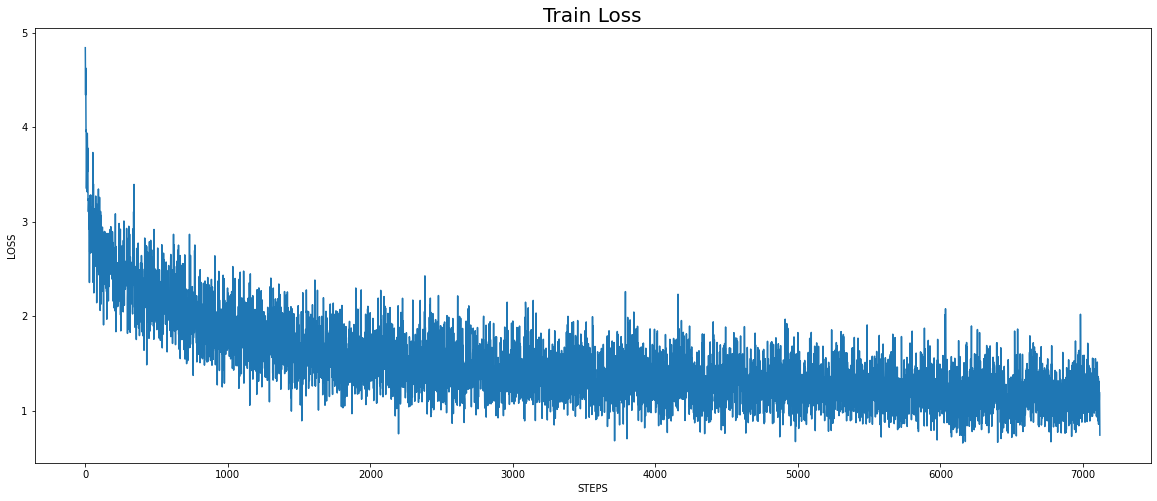

In [23]:
plt.figure(figsize=(20,8))
plt.plot(train_loss)
plt.title('Train Loss', size = 20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

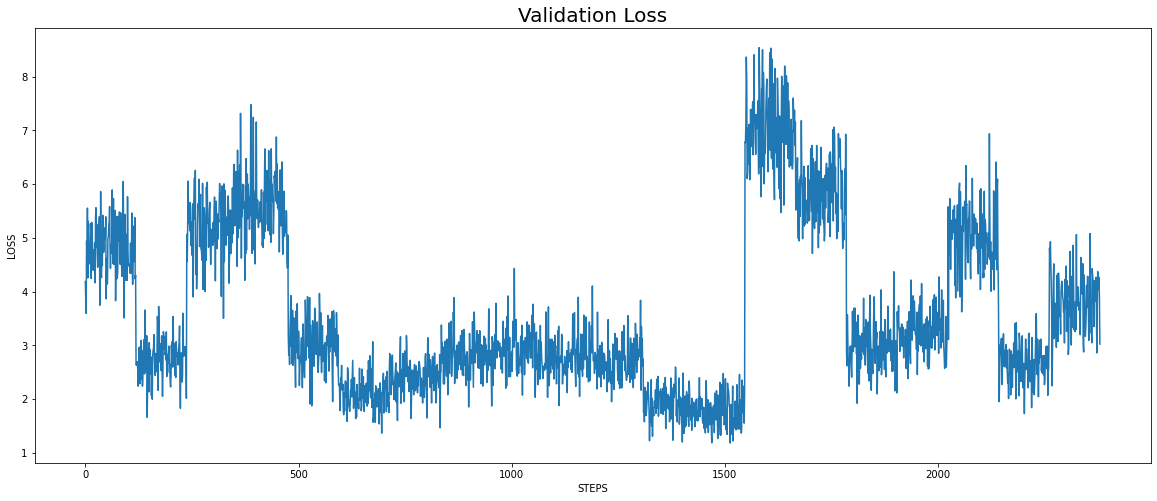

In [24]:
plt.figure(figsize=(20,8))
plt.plot(val_loss)
plt.title('Validation Loss', size = 20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

# Prediction :
---

 In this step we will load the best fitted model and then cretae the submission dataframe and then poplate that data on a `.csv` file.

In [25]:
best_model = torch.load('./best_model.pth')
cprint(best_model, 'blue')

PlankNet(
  (model): Sequential(
    (0): Conv(
      (seq): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      

In [26]:
# to filter only the names of the images

def preprocess_names(names_list):
    name_list = []
    for name in names_list:
        name_list.append(name.split('/')[-1])
    return name_list

In [27]:
# Test data generating function

def create_submission_file(test_dataloader, model, class_names):
    df = pd.DataFrame()
    model.eval()
    sf_layer = nn.Softmax(dim = 1)
    with torch.no_grad():
        for index, (test_patch, attr) in enumerate(test_dataloader):  # loading test data
            paths = preprocess_names(attr[1])
            test_patch = test_patch.cuda()
            op = model(test_patch)
            op = sf_layer(op)
            paths = np.array(list(paths))   #adding the filenames in a list
            op = op.cpu().detach().numpy()
            patch_df = pd.DataFrame(op, columns = class_names)  #creating the patch dataframe
            patch_df.insert(0, 'image', paths)
            df = pd.concat([df, patch_df], axis = 0)    # joining the patch dataframe with the main one.
            
            if index % 100 == 99:
                print(f"{index + 1} Steps Completed...\n")    
    print('Test Dataframe Generated...\n')
    
    return df

In [28]:
best_model = best_model.cuda()
pred_df = create_submission_file(test_dl, best_model, class_names)
pred_df.head()

100 Steps Completed...

200 Steps Completed...

300 Steps Completed...

400 Steps Completed...

500 Steps Completed...

600 Steps Completed...

700 Steps Completed...

800 Steps Completed...

900 Steps Completed...

1000 Steps Completed...

1100 Steps Completed...

1200 Steps Completed...

1300 Steps Completed...

1400 Steps Completed...

1500 Steps Completed...

1600 Steps Completed...

1700 Steps Completed...

1800 Steps Completed...

1900 Steps Completed...

2000 Steps Completed...

Test Dataframe Generated...



,image,unknown_unclassified,protist_star,polychaete,trochophore_larvae,fish_larvae_very_thin_body,hydromedusae_narco_young,hydromedusae_solmundella,acantharia_protist_big_center,acantharia_protist_halo,...,chaetognath_other,appendicularian_slight_curve,unknown_blobs_and_smudges,protist_fuzzy_olive,appendicularian_s_shape,detritus_blob,tunicate_doliolid_nurse,shrimp_sergestidae,hydromedusae_typeE,copepod_calanoid
0,1.jpg,8.487970e-05,2.142374e-06,6.293581e-08,4.409305e-10,7.178121e-05,2.199108e-06,1.274356e-06,2.838425e-10,2.499833e-10,...,4.299062e-04,4.541879e-05,8.725287e-04,1.242027e-05,1.473653e-04,1.107193e-05,7.086653e-06,2.680616e-09,5.946421e-10,1.122553e-06
1,10.jpg,6.356054e-04,9.960363e-07,3.116141e-08,5.240684e-09,6.343806e-05,1.151502e-06,5.995470e-07,3.206606e-08,1.148375e-08,...,2.086156e-05,1.041389e-05,3.543684e-02,5.528693e-03,7.113363e-04,4.456056e-04,1.113332e-06,2.065350e-09,1.142296e-08,7.663158e-02
2,100.jpg,2.031143e-11,3.945319e-14,9.516954e-17,1.825840e-16,3.550464e-14,4.484660e-12,2.197753e-14,1.347127e-16,3.799712e-09,...,3.385447e-14,5.968601e-13,2.080382e-14,1.751269e-10,2.703300e-12,1.539301e-16,7.472437e-13,2.183129e-15,7.855749e-16,4.537435e-13
3,1000.jpg,2.461040e-05,1.787795e-05,2.311535e-06,3.648040e-09,4.369052e-07,3.865343e-07,2.238934e-06,1.145406e-07,2.722855e-07,...,1.447029e-05,2.173859e-06,1.110642e-03,3.412913e-05,1.154459e-04,2.730363e-04,3.828102e-06,1.220803e-06,3.423915e-08,7.313919e-01
4,10000.jpg,2.456494e-05,2.782873e-08,6.503142e-10,1.674953e-09,1.066909e-13,5.141517e-09,2.098478e-10,7.251490e-09,2.179858e-11,...,3.233279e-12,8.378859e-12,1.588824e-03,2.381576e-07,8.264302e-11,2.726326e-04,7.411025e-11,3.295878e-13,3.959734e-09,7.342848e-09


Now, we need to do a last sanity chcek if the dataframe is okay or not.

In [29]:
# Checking if all the imae names are different
assert pred_df['image'].nunique() == pred_df.shape[0], " Submission format not correct!"
cprint('Submission correcty created !', 'green')

Submission correcty created !


### Creating `submission.csv` file

In [30]:
pred_df.to_csv('submission.csv', index = False)

<div align="center"><h1>HURRAH!</h1></div>

Now, We've completed the whole project. 
## Do ***UPVOTE*** this notebook.
Follow me on [GitHub](https://github.com/sagnik1511) and also in [Kaggle](https://kaggle.com/sagnik1511).

<div align="center"><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_Q8nZAYAx2FCzHlmWUnZjOjVHtSGQUehJ9w&usqp=CAU"></div>